#  Better Buy: A Stock Joint-Analysis and Comparison Tool

"Better Buy" is an interactive tool I've created that performs joint analysis and comparisons of two tech companies' business strategies, stock performances, and growth opportunities and recommends the better stock to investors. This model also provides users with detailed visualizations of key growth, performance, and risk metrics to base their decisions. 

"Better Buy" consists of highly-detailed implementations of business and technical analysis strategies for both growth and value-driven investors. The tool's analytics capabilities rely on a number of scripts I've written totally from scratch. 

My tool also uses pandas and numPy for in-depth analysis, as well as matplotlib/seaborn for data visualization. I've also imported the yfinance library to access historical stock quotes.

For this Notebook, I will be using my model to compare the two major fintech payment companies: Square (SQ) and PayPal (PYPL). 

Each of the four major sections (Business Strategy, Financial Strength & Growth, Risk vs. Return, and Valuation) will begin with a series of guided questions which serve as subtopics for my analysis.

### Business Strategy ###

What is the customer base behind each company and how effectively does each leverage this base?
What is the historical reputation of each company and its business model in the context of industry?
How does each company's organizational structure and recent M&A history affect its appearance to investors?
What are some current developments headed by each company and how well do they capitalize on AI?
What are some opinions of each company's operational directions as held by shareholders and client businesses?

### Stock Risk & Return Analysis ###
What was the moving average of our stocks?
What was the daily return average of a stock?
What was the correlation between daily returns of different stocks?
How much value do we put at risk by investing each company's stock?

How can we attempt to predict future stock behavior, especially in market and industry context?


## Financial Strength & Growth ##

This section utilizes 10-K and 10-Q filings from SEC's public EDGAR database. I've written a script that parses raw XML data from company filings and converts them into workable Pandas dataframes. 


In [1]:
from bs4 import BeautifulSoup
import requests
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('whitegrid')
%matplotlib inline

#Choosing company, file version, and date
file = '10-Q'
end = '20191231'
cik1 = '0001512673' #Square
cik2 = '0001633917' #PayPal
xmlList1 = []
xmlList2 = []
xmlList1.append('https://www.sec.gov/Archives/edgar/data/1512673/000151267319000011/q2fy19squareinc10-q_htm.xml')
xmlList2.append('https://www.sec.gov/Archives/edgar/data/1633917/000163391719000180/pypl10-qq22019_htm.xml')

url = "https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={}&type={}&dateb={}"
urlstr1 = requests.get(url.format(cik1, file, end)).text
urlstr2 = requests.get(url.format(cik2, file, end)).text

# Loop through files separated by year
soup = BeautifulSoup(urlstr1, 'html.parser')
table = soup.find('table', class_='tableFile2')
rows = table.find_all('tr')
for row in rows:
    cells = row.find_all('td')
    if len(cells) > 3:
        #Parsing all suitable XML files
        if '2017' or '2018' or '2019' in cells[3].text:
            html = 'https://www.sec.gov' + cells[1].a['href']
            htmlstr = requests.get(html).text
            soup = BeautifulSoup(htmlstr, 'html.parser')
            table = soup.find('table', class_='tableFile', summary='Data Files')
            rows = table.find_all('tr')
            for row in rows:
                cells = row.find_all('td')
                if len(cells) > 3:
                    xmlink = 'https://www.sec.gov' + cells[2].a['href']
                    xmlList1.append(xmlink)
                    break   
soup = BeautifulSoup(urlstr2, 'html.parser')
table = soup.find('table', class_='tableFile2')
rows = table.find_all('tr')
for row in rows:
    cells = row.find_all('td')
    if len(cells) > 3:
        #Parsing all suitable XML files
        if '2017' or '2018' or '2019' in cells[3].text:
            html = 'https://www.sec.gov' + cells[1].a['href']
            htmlstr = requests.get(html).text
            soup = BeautifulSoup(htmlstr, 'html.parser')
            table = soup.find('table', class_='tableFile', summary='Data Files')
            rows = table.find_all('tr')
            for row in rows:
                cells = row.find_all('td')
                if len(cells) > 3:
                    xmlink = 'https://www.sec.gov' + cells[2].a['href']
                    xmlList2.append(xmlink)
                    break 

### What are the historical revenues and opearting income growth of each company?###

We'll first analyze revenue growth of each company, segmented into domestic/international as well as by revenue type, such as subscription-based, transaction-based, and Bitcoin-based.

Next, I'll compare each company's revenue with operating income in order to compute each company's operating margin trend and assess their underlying business risks. The below code shows the organization of raw XML data into a neat DataFrame, organized by revenue type and quarter.

In [2]:
cols = ['2015Q1','2015Q2','2015Q3', '2016Q1', '2016Q2', '2016Q3','2017Q1','2017Q2','2017Q3',
                             '2018Q1','2018Q2','2018Q3','2019Q1','2019Q2']
df = pd.DataFrame(None, index=['Net Revenue','Subscription-Based Revenue','Transaction-Based Revenue','Bitcoin Revenue',
                               'US Revenue','Non-US Revenue'], 
                  columns = cols)
for link in xmlList1:
    xbrl_resp = requests.get(link)
    xbrl_str = xbrl_resp.text
    # Revenue is categorized based on geography, type of revenue
    soup = BeautifulSoup(xbrl_str, 'lxml')
    tag_list = soup.find_all(lambda tag: tag.name == 'us-gaap:revenues' or tag.name == 'us-gaap:salesrevenuenet'
                            or tag.name == 'us-gaap:salesrevenueservicesnet'
                            or tag.name == 'us-gaap:revenuefromcontractwithcustomerexcludingassessedtax')
    for tag in tag_list:
        contextStr = tag.get('contextref')  
        #print(contextStr)
        qtr = contextStr[2:8]
        if tag.text == '0':
            continue
        if 'YTD' not in contextStr or 'Q1' in contextStr:
            #Constraints for different XML labels
            if len(contextStr) == 11:
                df.at['Net Revenue', qtr]= tag.text
            if 'US' in contextStr:
                df.at['US Revenue', qtr]= tag.text
            if 'NonUsMember' in contextStr:
                df.at['Non-US Revenue', qtr]= tag.text
            if 'DataProducts' in contextStr:
                df.at['Subscription-Based Revenue', qtr]= tag.text
            if 'Transaction' in contextStr and '_StarbucksMember' not in contextStr:
                df.at['Transaction-Based Revenue', qtr]= tag.text
            if 'Cryptocurrency' in contextStr:
                df.at['Bitcoin Revenue', qtr] = tag.text
        #print("Revenues: " + tag.text)
df

,2015Q1,2015Q2,2015Q3,2016Q1,2016Q2,2016Q3,2017Q1,2017Q2,2017Q3,2018Q1,2018Q2,2018Q3,2019Q1,2019Q2
Net Revenue,250557000,310013000,332188000,379269000,438533000,439002000,461554000,551505000,585159000,668603000,814938000,882108000,959359000,1174238000
Subscription-Based Revenue,8006000,12928000,14694000,23796000,29717000,35320000,49060000,59151000,65051000,96995000,134332000,166037000,218857000,216491000
Transaction-Based Revenue,211110000,259864000,280955000,300453000,364864000,388347000,403478000,482065000,510019000,523037000,625228000,655384000,656762000,775510000
Bitcoin Revenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34095000,37016000,42963000,65528000,125085000
US Revenue,242955000,299326000,320858000,367164000,421808000,421317000,444899000,530008000,559053000,640173000,777335000,838149000,914656000,1119039000
Non-US Revenue,7602000,10687000,11330000,12105000,16725000,17685000,16655000,21497000,26106000,28430000,37603000,43959000,44703000,55199000


Just from skimming the dataframe, we notice some key details:

1. Net revenue has improved steadily, while Square has converted new opportunities such as Bitcoin into valuable sources of revenue. 

2. The vast discrepancy between US and non-US revenue, which could mean that Square has tremendous room to grow in international fintech markets. 

Text(0,0.5,'Dollars (in 100 Millions)')

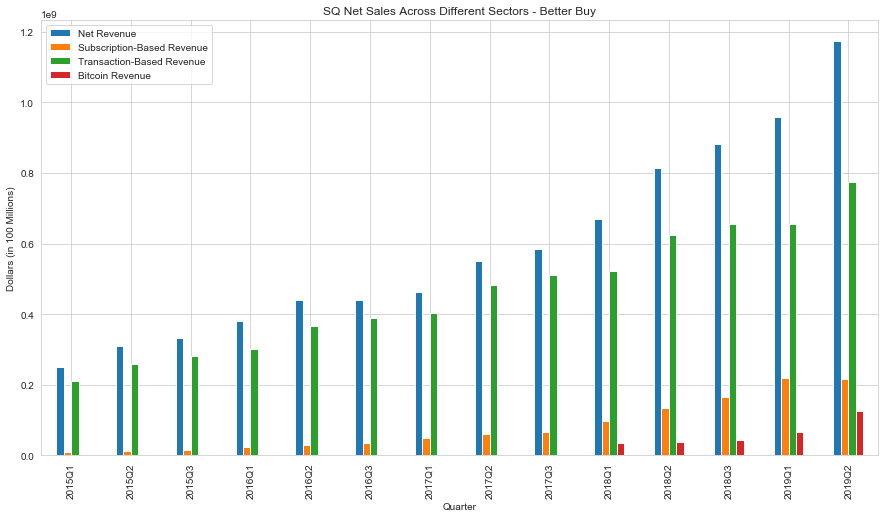

In [3]:
df=df.astype(float)
revdf = pd.DataFrame({"Net Revenue":df.iloc[0],"Subscription-Based Revenue":df.iloc[1],
                     "Transaction-Based Revenue":df.iloc[2], "Bitcoin Revenue": df.iloc[3]})
revax = revdf.plot.bar(legend = True,title="SQ Net Sales Across Different Sectors - Better Buy",figsize=(15,8))
revax.set_xlabel("Quarter")
revax.set_ylabel("Dollars (in 100 Millions)")

This bar graph indicates consistent growth in revenue for Square. Each quarter the company has posted approximately 50% growth in net revenue year-over-year, a promising indication for a company with increasingly diverse revenue streams. While transaction-based revenue has posted steady growth, other streams such as subscription-based and bitcoin revenue exhibit consistent upward trends that will likely continue with the industry's tech-driven direction.

In [4]:
df = pd.DataFrame(None, index=['Operating Profit - SQ','Operating Growth - SQ','Operating Profit - PYPL',
                              'Operating Growth - PYPL'], 
                  columns = cols)
for link in xmlList1:
    
    xbrl_resp = requests.get(link)
    xbrl_str = xbrl_resp.text

    soup = BeautifulSoup(xbrl_str, 'lxml')
    tag_list = soup.find_all(lambda tag: tag.name == 'us-gaap:operatingincomeloss')
    for tag in tag_list:
        contextStr = tag.get('contextref')
        index = contextStr[2:8]
        qtr = contextStr[6:8]
        if contextStr[8:] == 'QTD' or qtr == 'Q1':
            if len(contextStr) == 11:
                df.at['Operating Profit - SQ', index] = tag.text
        year = int(contextStr[2:6])
        if year != 2019  and index != '2018Q3':
            num1 = df.loc['Operating Profit - SQ', str(year+1)+qtr]
            num2 = df.loc['Operating Profit - SQ', str(year)+qtr]
            df.at['Operating Growth - SQ', str(year+1) + qtr] = (float(num2)-float(num1))/float(num2)*100

for link in xmlList2:
    xbrl_resp = requests.get(link)
    xbrl_str = xbrl_resp.text

    soup = BeautifulSoup(xbrl_str, 'lxml')
    tag_list = soup.find_all(lambda tag: tag.name == 'us-gaap:operatingincomeloss')
    for tag in tag_list:
        contextStr = tag.get('contextref')  
        index = contextStr[2:8]
        qtr = contextStr[6:8]
        year = int(contextStr[2:6])
        if(year < 2015):
            break
        if contextStr[8:] == 'QTD' or qtr == 'Q1':
            index = contextStr[2:8]
            if len(contextStr) == 11:
                df.at['Operating Profit - PYPL', index] = tag.text  
        if year != 2019  and index != '2018Q3':
            num1 = df.loc['Operating Profit - PYPL', str(year+1)+qtr]
            num2 = df.loc['Operating Profit - PYPL', str(year)+qtr]
            df.at['Operating Growth - PYPL', str(year+1) + qtr] = (float(num1)-float(num2))/float(num2)*100
df

,2015Q1,2015Q2,2015Q3,2016Q1,2016Q2,2016Q3,2017Q1,2017Q2,2017Q3,2018Q1,2018Q2,2018Q3,2019Q1,2019Q2
Operating Profit - SQ,-46350000,-28074000,-52217000,-97133000,-27360000,-31982000,-14082000,-12224000,-14891000,-20992000,-2647000,-9867000,-22042000,-843000
Operating Growth - SQ,NaN,NaN,NaN,-109.564,2.54328,38.7517,85.5024,55.3216,53.4394,-49.0697,78.3459,33.7385,-5.00191,68.1526
Operating Profit - PYPL,322000000,398000000,330000000,407000000,371000000,348000000,431000000,430000000,423000000,534000000,572000000,490000000,518000000,705000000
Operating Growth - PYPL,NaN,NaN,NaN,26.3975,-6.78392,5.45455,5.89681,15.903,21.5517,23.8979,33.0233,15.8392,-2.99625,23.2517


Since Square has posted a net loss every quarter while PayPal has generated positive net incomes, it is better to compare their historical growth trends (Year-Over-Year) to capture the current outlook and growth potentials of the two companies.

Text(0,0.5,'Percent')

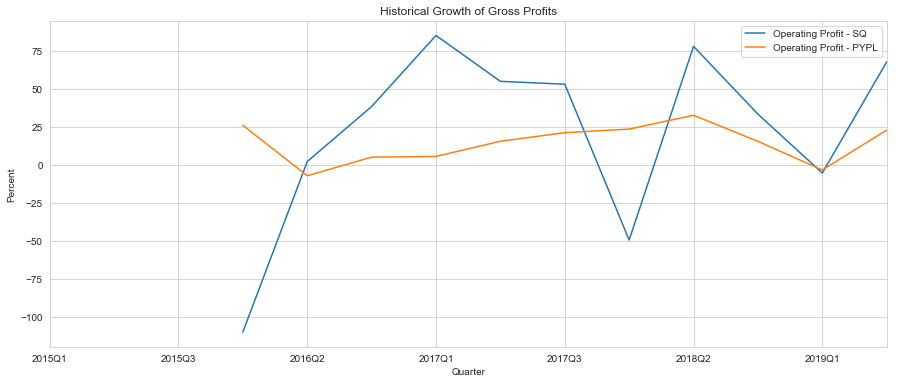

In [5]:
df=df.astype(float)
revdf = pd.DataFrame({"Operating Profit - SQ":df.iloc[1], "Operating Profit - PYPL": df.iloc[3]})
revax = revdf.plot.line(legend = True,title="Historical Growth of Gross Profits",figsize=(15,6))
revax.set_xlabel("Quarter")
revax.set_ylabel("Percent")

Analyzing the growth trends yields a much better comparison. Two takeaways:

1) Square is a more volatile stock. Since it's relatively newer, the company has enjoyed surges and suffered dips corresponding with the decline in product popularity (ex: Caviar) and the introduction of new products (ex: CashApp)

2) PayPal's stock has posted generally stable, but positive returns. This is another indicator that its a market staple in the p2p payment industry and will likely maintain positive revenue growth
#### Bottom Line ####
While Square has rebounded nicely from revenue plunges every 1.5-2 years and has strong potential for >75% growth in operating margins, PayPal's steadily-growing operating margins and high revenue suggest stronger management and lower business risk. There's strong indications that it's a safer and stronger company to buy.

### What are the operating and free cash flows that each company maintains?###




What are the projected cash flow returns for each company and how does that affect their Net Present Value (NPV)?<br>
How do the companies' cash assets compare to their debts and other liabilities?<br>
How well has each company taken advantage of emerging markets and what is their revenue potential in these markets?<br>
How much will each company increase its earnings per share ratio and operating profits?<br

## Valuation ##

### What is the company's NOPAT (Net Operating Profit After Tax) growth and stock price projection? ###

Since SQ has posted no operating profits, the effective tax rate is 0 and thus NOPAT growth is idential to operating profit growth. However, PYPL has posted operating profits, so we'll create a new dataframe that calculates the NOPAT and NOPAT growth of PYPL. 


In [6]:
nop = pd.DataFrame(None, index=['NOPAT - SQ','NOPAT - PYPL','NOPAT Growth - PYPL'], 
                  columns = cols)
for link in xmlList2:
    xbrl_resp = requests.get(link)
    xbrl_str = xbrl_resp.text
    soup = BeautifulSoup(xbrl_str, 'lxml')
    tag_list = soup.find_all(lambda tag: tag.name == 'us-gaap:effectiveincometaxratecontinuingoperations')
    for tag in tag_list:
        contextStr = tag.get('contextref')  
        index = contextStr[2:8]
        qtr = contextStr[6:8]
        if contextStr[8:] == 'QTD' or qtr == 'Q1':
            index = contextStr[2:8]
            if len(contextStr) == 11:
                nop.at['NOPAT - PYPL', index] = df.iloc[2][index]*(1-float(tag.text)) 
        year = int(contextStr[2:6])
        if year != 2019  and index != '2018Q3':
            num1 = nop.loc['NOPAT - PYPL', str(year+1)+qtr]
            num2 = nop.loc['NOPAT - PYPL', str(year)+qtr]
            nop.at['NOPAT Growth - PYPL', str(year+1) + qtr] = (float(num1)-float(num2))/float(num2)*100
nop

,2015Q1,2015Q2,2015Q3,2016Q1,2016Q2,2016Q3,2017Q1,2017Q2,2017Q3,2018Q1,2018Q2,2018Q3,2019Q1,2019Q2
NOPAT - SQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOPAT - PYPL,2.55668e+08,3.04072e+08,2.838e+08,3.52055e+08,3.1535e+08,3.132e+08,3.7928e+08,3.956e+08,3.5532e+08,4.9662e+08,4.9192e+08,4.018e+08,4.8174e+08,6.1335e+08
NOPAT Growth - PYPL,NaN,NaN,NaN,36.9041,3.70899,10.3594,7.73317,25.4479,13.4483,30.9376,24.3478,13.0812,-2.99625,24.6849


Now let's plot the historical NOPAT growth of PYPL along with a line of best fit assuming a 68% confidence interval. 

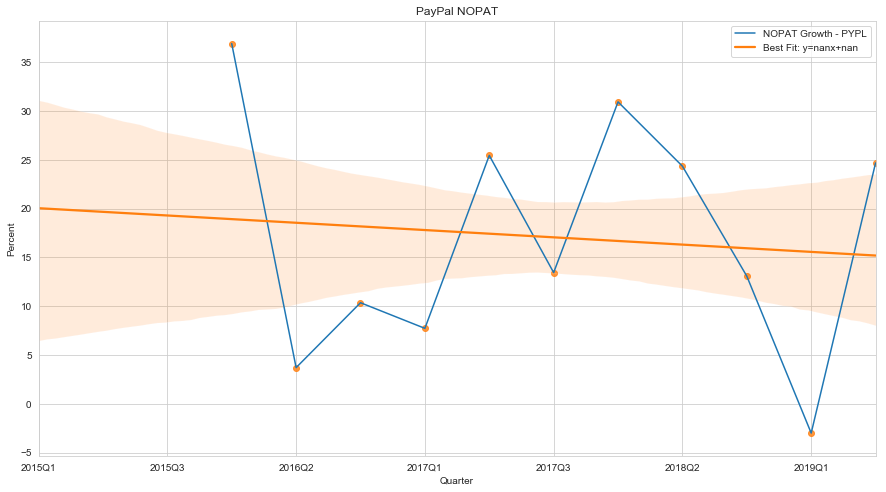

nan

In [11]:
df=df.astype(float)
revdf = pd.DataFrame({"NOPAT Growth - PYPL":nop.iloc[2]})
revax = revdf.plot.line(legend = True,title="PayPal NOPAT",figsize=(15,8))
revax.set_xlabel("Quarter")
revax.set_ylabel("Percent")
x =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
y = nop.iloc[2].tolist()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
sns.regplot(x = x, y = y, ci = 68, data=revdf, fit_reg=True,line_kws={'label':"Best Fit: y={0:.1f}x+{1:.1f}".format(slope,intercept)}) 

revax.legend()

plt.show()
p_value


What are each company's P/Free Cash Flow and how should that affect pricing?
What do each company's Forward and Trailing P/E ratios tell?

When are each company's EBITDA ratios?